This is an attempt to recreate the parameter estimation [example](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-10.html) from James Rawlings book on [Reactor Design](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/) using Pyomo.

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae

In [5]:
data_df_1 = pd.read_csv('../../learn_kipet/my_data_sets/ABCD_cb0_2_temp_298.csv', index_col = 0)
data_df_1.head()

,A,B,C,D,T
0.000000,0.999430,2.026647,-0.021488,-0.092859,298
0.311111,0.657779,1.465442,0.212230,0.217942,298
0.666667,0.393358,1.057921,0.304588,0.407075,298
0.977778,0.291383,0.817799,0.192745,0.566569,298
1.333333,0.132911,0.574218,0.124419,0.609271,298


In [6]:
data_df_2 = pd.read_csv("../../learn_kipet/my_data_sets/ABCD_cb0_1_T_298.csv", index_col = 0)
data_df_2.head()

,A,B,C,D,T
0.000000,1.049573,0.942065,-0.014951,-0.022228,298
0.544445,0.764401,0.563160,0.285190,0.177670,298
1.166667,0.545324,0.348745,0.220505,0.199405,298
1.711111,0.495911,0.143160,0.246272,0.378067,298
2.333333,0.485043,0.169657,0.309152,0.284624,298


In [7]:
data_df_3 = pd.read_csv("../../learn_kipet/my_data_sets/ABCD_cb0_1_T_273.csv", index_col = 0)
data_df_3.head()

,A,B,C,D,T
0.000000,0.900899,2.012470,0.008105,0.011200,273
1.166667,0.480168,1.194384,0.382285,0.193608,273
2.500000,0.140865,0.710956,0.348401,0.486773,273
3.666667,0.179051,0.579542,0.227455,0.466939,273
5.000000,0.164998,0.439625,0.265172,0.637897,273


In [94]:
# Convert data to a list of dictionaries
data = [{'A': {k:v for (k, v) in zip(data_df_1.index, data_df_1.A)},
         #'B': {k:v for (k, v) in zip(data_df_1.index, data_df_1.B)},
    #'C': {k:v for (k, v) in zip(data_df_1.index, data_df_1.C)},
          'D': {k:v for (k, v) in zip(data_df_1.index, data_df_1.D)},
       'init': {'A': 1, 'B': 2, 'C': 0, 'D':0, 'T':298}}]
data.append(
{
    #'A': {k:v for (k, v) in zip(data_df_2.index, data_df_2.A)},
    'B': {k:v for (k, v) in zip(data_df_2.index, data_df_2.B)},
    #'C': {k:v for (k, v) in zip(data_df_2.index, data_df_2.C)},
    'D': {k:v for (k, v) in zip(data_df_2.index, data_df_2.D)},
       'init': {'A': 1, 'B': 1, 'C': 0, 'D':0, 'T':298}}
)
data.append(
{'A': {k:v for (k, v) in zip(data_df_3.index, data_df_3.A)},
    'B': {k:v for (k, v) in zip(data_df_3.index, data_df_3.B)},
    'C': {k:v for (k, v) in zip(data_df_3.index, data_df_3.C)},
     #'D': {k:v for (k, v) in zip(data_df_3.index, data_df_3.D)},
       'init': {'A': 1, 'B': 2, 'C': 0, 'D':0, 'T':273}}
)


In [95]:
def genblock(b, k):
    b.dummy = pyo.Param(initialize = 1)


In [96]:
def ABC_model(m, b, data, disctype, sim):
    
    species = ['A', 'B', 'C', 'D']
    id_species = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    Tref = 298
    R = 8.314e-3
    T = data['init']['T']
    
    S = np.array([[-1.0, -1.0, 1.0, 0.0],
                  [0.0, -1.0, -1.0, 1.0]
                 ])
    
    rxns = [0, 1]
    
    meas_t = np.array([list(data[k].keys()) for k in data.keys() if k in species])
    meas_t = list(np.unique(meas_t.flatten()))
    max_t = np.max(meas_t)
           
    c0 = {k:data['init'][k] for k in species}
    
    def _c_init_rule(b, t, j):
        return c0[j]
    
    b.errsq = pyo.Var(within = pyo.NonNegativeReals)
    b.time = dae.ContinuousSet(bounds = (0.0, max_t), initialize = meas_t)
    b.c = pyo.Var(b.time, species, initialize = _c_init_rule, bounds = (0, 2))
    
    b.dc = dae.DerivativeVar(b.c, wrt = b.time)
    
    def _dcrate(b, t, j):
        
        nrxn = S.shape[0]
        nspec = S.shape[1]
        rrate = {}
        for i in range(nrxn):
            rrate[i] = m.k[i] * pyo.exp(-m.Ea[i]/R * (1/T - 1/Tref))
            for j2 in range(nspec):
                if S[i, j2] < 0:
                    rrate[i] = rrate[i] * b.c[t, species[j2]]
        
        if t == 0:
            return pyo.Constraint.Skip
        else:
            return b.dc[t, j] == sum(S[i, id_species[j]] * rrate[i] for i in rxns)

    def _dcrate_sim(b, t, j):
        nrxn = S.shape[0]
        nspec = S.shape[1]
        rrate = {}
        for i in range(nrxn):
            rrate[i] = m.k[i] * pyo.exp(-m.Ea[i]/R * (1/T - 1/Tref))
            for j2 in range(nspec):
                if S[i, j2] < 0:
                    rrate[i] = rrate[i] * b.c[t, species[j2]]
        return b.dc[t, j] == sum(S[i, id_species[j]] * rrate[i] for i in rxns)
    
    if sim == 0:
        b.dcrate = pyo.Constraint(b.time, species, rule = _dcrate)
    else:
        b.dcrate = pyo.Constraint(b.time, species, rule = _dcrate_sim)
    
    for j in species:
        b.c[0, j].fix(c0[j])
    
    def _errsq_rule(b):
        expr = 0
        for j in species:
            if j in data.keys():
                expr = expr + sum((b.c[t, j] - data[j][t]) ** 2 for t in meas_t) 
        return b.errsq == expr 
    b.errsq_cons = pyo.Constraint(rule=_errsq_rule)
    
    if disctype == 'colloc':
        disc = pyo.TransformationFactory('dae.collocation')
        disc.apply_to(b, nfe=20, ncp=2)
    else:
        disc = pyo.TransformationFactory('dae.finite_difference')
        disc.apply_to(b, nfe=500, scheme = 'BACKWARD')
    
    return m

In [97]:
def get_model():
    m = pyo.ConcreteModel()

    rxns = [0, 1]
    m.k = pyo.Var(rxns, initialize = 0.5, bounds = (1e-4, 10))
    m.Ea = pyo.Var(rxns, initialize = 20, bounds = (0.0, 100.0))
    
    expts = [0, 1, 2]
    
    def genblock(b, k):
        b.dummy = pyo.Param(initialize = 1)
    m.b = pyo.Block(expts, rule = genblock)
    
    for e in expts:
        m = ABC_model(m, m.b[e], data[e], 'colloc', 0)
    
    m.obj = pyo.Objective(expr = sum(m.b[e].errsq for e in expts), sense = pyo.minimize)
    
    return m

In [98]:
m = get_model()

In [99]:
solver = pyo.SolverFactory('ipopt')
solver.solve(m, tee = True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     4623
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      968

Total number of variables............................:      967
                     variables with only lower bounds:        3
                variables with lower and upper bounds:      484
                     variables with only upper bounds:        0
Total number of equality constraints.................:      963
Total number of inequali

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 963, 'Number of variables': 967, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.1776270866394043}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [100]:
# Estimated parameters
m.k[0](), m.k[1](0)

(0.8910820669494302, 2.161485618881116)

In [101]:
m.Ea[0](), m.Ea[1]()

(16.525930539868558, 37.70914226817421)

In [29]:
T = 273
Tref = 298
R = 8.314e-3
Ea0_est = np.log(0.5/1)*(-R/(1/T - 1/Tref))
Ea0_est

18.753156747062167

In [30]:
T = 273
Tref = 298
R = 8.314e-3
Ea1_est = np.log(0.5/2)*(-R/(1/T - 1/Tref))
Ea1_est

37.506313494124335

In [110]:
e = 1

time = list(m.b[e].time)
c = {j:[m.b[e].c[t, j]() for t in time] for j in ['A', 'B', 'C', 'D']}

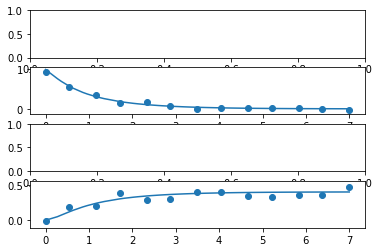

In [111]:
fig, ax = plt.subplots(4)
for i, j in enumerate(['A', 'B', 'C', 'D']):
    if j in data[e].keys():
       ax[i].scatter(data[e][j].keys(), data[e][j].values())
       ax[i].plot(time, c[j])